# Version 1: Basic Evolutionary Programming (EP)
* Implement a basic version of EP to optimize the portfolio weights, focusing on
maximizing the expected return.

In [9]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from statisticscalc import analyze_convergence, validate_and_plot


In [17]:
# Load data and set parameter values

# Load monthly returns data
monthly_returns_df = pd.read_csv('data/monthlyreturn/monthlyreturnstocks.csv')
monthly_returns_df = monthly_returns_df.select_dtypes(include=[np.number])  # Keep only numeric columns

# Define parameters
population_size = 100    # Number of portfolios
num_generations = 1000   # Number of generations
mutation_rate = 0.1      # Mutation probability
num_months = len(monthly_returns_df)  # Total months in the dataset
num_assets = monthly_returns_df.shape[1]  # Number of stocks/assets
cov_matrix = monthly_returns_df.cov().to_numpy()

# EP functions

In [14]:
# Initialize population with each month allocated to 100% using dirichlet
# This applies a random allocation of weights between each month for the stocks. 
def initialize_population(size, num_months, num_assets):
    population = np.array([np.array([np.random.dirichlet(np.ones(num_assets)) for _ in range(num_months)]) for _ in range(size)])
    return population

# Define mutation function
def mutate(portfolio, mutation_rate):
    """
    Takes in the portfolio, 
    asigns gaussian noise to the original portfolio, ensuring no negative numbers
    and ensures every month has exaclty 1 assigned to all stocks
    """
    mutated_portfolio = portfolio + np.random.normal(0, mutation_rate, size=portfolio.shape)
    mutated_portfolio = np.abs(mutated_portfolio)
    mutated_portfolio /= mutated_portfolio.sum(axis=1, keepdims=True)  # Normalize each month to sum to 1
    return mutated_portfolio

# Fitness function with cumulative compounding
def calculate_fitness(portfolio):

    """
    Calculates each months return and uses calcultes the return cumulatively for each month
    """
    monthly_returns = monthly_returns_df.to_numpy()
    cumulative_growth = 1.0  # Start with initial growth factor of 1 (100%)

    for month in range(num_months):
        month_weights = portfolio[month]
        month_return = np.dot(month_weights, monthly_returns[month])  # Weighted return for this month
        cumulative_growth *= (1 + month_return / 100)  # Compound the cumulative growth with this month's return

    cumulative_return = (cumulative_growth - 1) * 100  # Represent as percentage
    return cumulative_return


# Fitness function with cumulative compounding and risk penalty
def calculate_fitness_cov(portfolio, risk_tolerance=0.1):
    """
    Calculates each month's return and compounds it.
    Adds a penalty for risk based on the portfolio's variance using the covariance matrix.
    """
    monthly_returns = monthly_returns_df.to_numpy()  # Assuming this DataFrame is pre-loaded
    cumulative_growth = 1.0  # Start with an initial growth factor of 1 (100%)
    portfolio_risk_total = 0  # Accumulate portfolio risk for all months
    
    # Calculate cumulative return and risk
    for month in range(portfolio.shape[0]):
        month_weights = portfolio[month]
        
        # Calculate monthly return
        month_return = np.dot(month_weights, monthly_returns[month])  # Weighted return for this month
        cumulative_growth *= (1 + month_return / 100)  # Compound growth with this month's return
        
        # Calculate portfolio variance (risk) using the covariance matrix
        month_variance = np.dot(month_weights.T, np.dot(cov_matrix, month_weights))
        month_risk = np.sqrt(month_variance)  # Risk as standard deviation
        portfolio_risk_total += month_risk

    # Final cumulative return as a percentage
    cumulative_return = (cumulative_growth - 1) * 100  # Represent as percentage

    # Adjust fitness to include risk (penalize high-risk portfolios)
    fitness_score = cumulative_return - risk_tolerance * portfolio_risk_total
    return fitness_score

# Selection function
def select_best(population, fitness, num_to_select):
    sorted_indices = np.argsort(fitness)[::-1] # Uses sort algorithm to sort the best population to the top
    return population[sorted_indices[:num_to_select]] 

# EP Version 1

In [15]:
# Main Evolutionary Programming loop
def Basic_EP_V1(population_size, num_generations , mutation_rate, num_months, num_assets):
    start_time = time.time()
    population = initialize_population(population_size, num_months, num_assets)
    generation_plot=[]
    for generation in range(num_generations):
        fitness_scores = np.array([calculate_fitness_cov(portfolio) for portfolio in population])

        # Select top half of the population
        population = select_best(population, fitness_scores, population_size // 2)

        # Generate new population with mutations
        new_population = [mutate(portfolio, mutation_rate) for portfolio in population]
        population = np.array(population.tolist() + new_population)

        

        best_return = np.max(fitness_scores)
        generation_plot.append(best_return)
        
        if generation % 100 == 0:
            print(f"Generation {generation}: Best Cumulative Return = {best_return:.4f}")
            

    # Final optimized portfolio
    best_portfolio = population[np.argmax(fitness_scores)]
    end_time = time.time()- start_time
    return best_portfolio, generation_plot, best_return, end_time


Generation 0: Best Cumulative Return = 144.6044
Generation 100: Best Cumulative Return = 169.3451
Generation 200: Best Cumulative Return = 172.9077
Generation 300: Best Cumulative Return = 172.9077
Generation 400: Best Cumulative Return = 172.9077
Generation 500: Best Cumulative Return = 172.9077
Generation 600: Best Cumulative Return = 177.6180
Generation 700: Best Cumulative Return = 195.5269
Generation 800: Best Cumulative Return = 195.5269
Generation 900: Best Cumulative Return = 195.5269
Convergence achieved at generation: 146
Time to convergence: 5.25 seconds
Best Return: 195.52691037162523
Total Time: 35.94 seconds
All monthly allocations sum to 1.


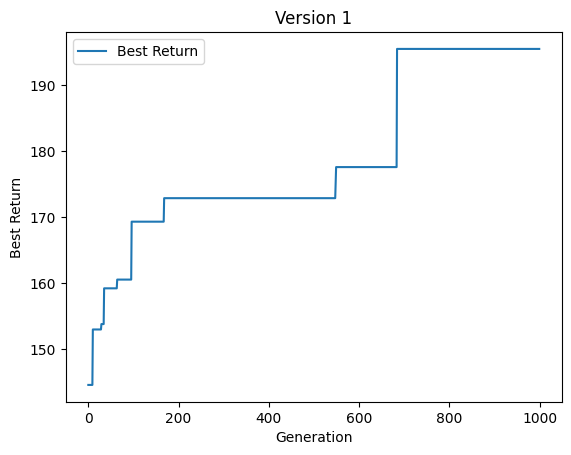

In [18]:

# Run the EP optimization
best_portfolio, generation_plot, best_return, end_time = Basic_EP_V1(population_size, num_generations , mutation_rate, num_months, num_assets)

analyze_convergence(generation_plot, end_time)
# Display final results
print("Best Return:", best_return)
print(f"Total Time: {end_time:.2f} seconds")
validate_and_plot(best_portfolio, generation_plot, num_months, title="Version 1", output_file="results/Version_1.png")
